this notebook creates two maps that show the Hunza watershed with ESRI imagery
- first map overlays the algorithm calculated melt onset dates (MOD) for SIR pixels
- second map overlays the algorithm calculated melt onset dates (MOD) for GRD pixels

the pixel overlays are simply a scatter plot with rectangular markers and are not using EASE-grid projection

## Load in all the modules needed

In [ ]:
%pylab notebook
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
import pandas as pd
from cetbtools.ease2conv import Ease2Transform
from mpl_toolkits.basemap import Basemap
import glob

In [2]:
# navigate to where scripts are saved
% cd /mnt/data3/cetb/ipynb_melt_onset/scripts/

/mnt/data3/cetb/ipynb_melt_onset/scripts


In [3]:
# load the custom functions
from CETB_read_functions import read_Tb
from CETB_read_functions import coords
from CETB_read_functions import calc_DAV
from CETB_read_functions import find_cube_offset
from CETB_read_functions import grid_locations_of_subset
#from CETB_read_functions import find_UIB_cube_offset
#from CETB_read_functions import find_GLaIL_cube_offset
#from CETB_read_functions import grid_locations_of_UIB
#from CETB_read_functions import grid_locations_of_GLaIL
from CETB_algorithms import DAV_MOD
from CETB_analysis import MOD_array
from CETB_analysis import MOD_array_year

## Specify inputs

In [4]:
#Specify region, satellite, sensor, channel, and image reconstruction algorithm of interest in file name
# this notebook will read in 2 CETB datasets so that channels/algorithms/sensors can be compared
region='GLaIL'  #make this the same syntax as cubefilenames and sub-directory
sat_GRD='F18'   #'AQUA' for AMSRE, 'F13','F14','F15'... for SSMI
sat_SIR= 'F18'
sensor_GRD='SSMIS'  #'AMSRE', 'SSMI', etc.
sensor_SIR='SSMIS'
channel_GRD='37V'  #'36V','36H', '18V','18H', etc. '19V','19H' and '37V','37H' for SSMI)
channel_SIR='37V'
alg_GRD='GRD'   #SIR or GRD
alg_SIR='SIR'

if sensor_GRD=='SSMIS':
    provider='CSU' 
    version='v1.*' #note need to check for different sensors v1.2, 1.3, 1.4
elif sensor_GRD=='AMSRE':
    provider='RSS'
    version='v1.3'

# either change to the directory where the data is or specify it
datadir_GRD = '/mnt/data3/cetb/cubes/'+sat_GRD+'_'+sensor_GRD+'/'+region+'/' 
datadir_SIR = '/mnt/data3/cetb/cubes/'+sat_SIR+'_'+sensor_SIR+'/'+region+'/' 

# prefix filepath
prefix_GRD='CETB.cubefile.'+region+'.'+sat_GRD+'_'+sensor_GRD+'-'+channel_GRD+'-'+alg_GRD+'-'+provider+'-'+version
prefix_SIR='CETB.cubefile.'+region+'.'+sat_SIR+'_'+sensor_SIR+'-'+channel_SIR+'-'+alg_SIR+'-'+provider+'-'+version

# years for each sensor
if sat_GRD=='F13' or sat_SIR=='F13':
    Years = [2002,2003,2004,2005,2006,2007,2008,2009]
elif sat_GRD=='F14' or sat_SIR=='F14':
    Years=[2002,2003,2004,2005,2006,2007,2008]
elif sat_GRD=='F15' or sat_SIR=='F15':
    Years=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011]
elif sat_GRD=='F18' or sat_SIR=='F18':
    Years=[2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
elif sat_GRD=='AQUA' or sat_SIR=='AQUA':
    Years=[2003,2004,2005,2006,2007,2008,2009,2010,2011]

#Enter a site name for titles of plots
Site='Vatnajokull, Iceland'

In [5]:
# SPECIFY latitude and longitude in decimal degrees, need to choose lat/lon corners so that we will load
# in a rectangle of pixels within the corners of these coordinates
lat_start=63.75  #35.9
lat_end=64.88    #37.1
lon_start=-20 #-20 includes katla -18.5vatna    #74
lon_end=-15    #76

In [6]:
# get cube offset for finding row/col
# function is region specific
find_cube_offset(region,cubeType=None, verbose=False)

Reading offset information from cubeFile=/mnt/data3/cetb/cubes/AQUA_AMSRE/GLaIL/CETB.cubefile.GLaIL.AQUA_AMSRE-36V-SIR-RSS-v1.3.2006.TB.nc...


(2904.000000001132, 2063.999999962362)

In [7]:
# get the GRD pixel IDs for the lat/lon rectangle chosen
rows_cols_GRD=coords(datadir_GRD, prefix_GRD, lat_start, lat_end, lon_start, lon_end)
rows_cols_GRD

(102, 109, 63, 73)

In [8]:
# row and col numbers of all the SIR pixels contained by the GRD pixels
rows_cols_env=[rows_cols_GRD[0]*8,rows_cols_GRD[1]*8, rows_cols_GRD[2]*8, rows_cols_GRD[3]*8]
rows_cols_env

[816, 872, 504, 584]

In [9]:
# load in SIR TB data
data_SIR=read_Tb(datadir_SIR, prefix_SIR, Years,rows_cols_env[0],rows_cols_env[1],rows_cols_env[2],rows_cols_env[3])
CETB_SIR=data_SIR[0]   # 3-D Tb time-series array of TB
cal_date=data_SIR[1]    # 1-D array of dates, these will get passed to later functions
cal_year=data_SIR[2]    # 1-D array of years
cal_month=data_SIR[3]   # 1-D array of months

# load GRD Tb data
data_GRD=read_Tb(datadir_GRD, prefix_GRD, Years,rows_cols_GRD[0],rows_cols_GRD[1],rows_cols_GRD[2],rows_cols_GRD[3])
CETB_GRD=data_GRD[0]

In [10]:
# calculate DAV for the Tb data that was imported
DAV_SIR=calc_DAV(CETB_SIR)
DAV_GRD=calc_DAV(CETB_GRD)

## get the latitudes and longitudes of each pixel for plotting

In [11]:
#Get lat/lon of each pixel in the subset of 64
# these get used for plotting over basemap
filename=datadir_SIR+prefix_SIR+'.'+str(2019)+'.TB.nc'	
vlist=glob.glob(filename)
data=Dataset(vlist[-1], "r", format="NETCDF4")

lat=data.variables['latitude'] 
lat=lat[:]
lon=data.variables['longitude']
lon=lon[:]
lat_lon=np.dstack((lat,lon))

coordinates=lat_lon[rows_cols_env[0]:rows_cols_env[1],rows_cols_env[2]:rows_cols_env[3]]

coordinates=coordinates.reshape(((rows_cols_env[1]-rows_cols_env[0])*(rows_cols_env[3]-rows_cols_env[2])),2)
pixel_lats=coordinates[:,0]
pixel_lons=coordinates[:,1]

pixel_lats

array([64.70053823, 64.71050704, 64.72044743, ..., 63.85727418,
       63.86454984, 63.87179627])

In [12]:
#Get lat/lon for GRD pixels
# similar to SIR above
filename=datadir_GRD+prefix_GRD+'.'+str(2019)+'.TB.nc'	
vlist=glob.glob(filename)
data=Dataset(vlist[-1], "r", format="NETCDF4")

lat=data.variables['latitude'] 
lat=lat[:]
lon=data.variables['longitude']
lon=lon[:]
lat_lon=np.dstack((lat,lon))

coordinates=lat_lon[rows_cols_GRD[0]:rows_cols_GRD[1],rows_cols_GRD[2]:rows_cols_GRD[3]]

coordinates=coordinates.reshape(((rows_cols_GRD[1]-rows_cols_GRD[0])*(rows_cols_GRD[3]-rows_cols_GRD[2])),2)
pixel_lats_GRD=coordinates[:,0]
pixel_lons_GRD=coordinates[:,1]

pixel_lats_GRD

array([64.64087384, 64.7187557 , 64.79480296, 64.86900027, 64.94133249,
       65.01178467, 65.08034208, 65.14699023, 65.21171486, 65.27450199,
       64.42478943, 64.50205811, 64.57750288, 64.65110875, 64.72286092,
       64.79274482, 64.86074606, 64.92685051, 64.99104426, 65.05331367,
       64.20837134, 64.28503668, 64.3598887 , 64.43291276, 64.50409444,
       64.57341947, 64.64087384, 64.70644375, 64.77011563, 64.83187618,
       63.99162408, 64.06769569, 64.14196449, 64.21441618, 64.28503668,
       64.35381207, 64.42072865, 64.48577297, 64.54893179, 64.61019212,
       63.77455196, 63.85003925, 63.92373415, 63.99562271, 64.06569116,
       64.1339259 , 64.20031359, 64.26484106, 64.32749542, 64.38826399,
       63.55715913, 63.63207131, 63.70520144, 63.7765359 , 63.84606121,
       63.91376413, 63.97963159, 64.04365078, 64.10580908, 64.16609413,
       63.33944955, 63.41379565, 63.48636995, 63.55715913, 63.62615005,
       63.69332975, 63.75868548, 63.82220473, 63.88387518, 63.94

## create arrays of MOD to be used for plotting

In [18]:
# get array of average MODs for SIR pixels for all the years loaded
window=8   # window for MOD algorithm, '10' would be 5 days (2 measurements per day)
count=3    # number of Tb/DAV exceedances to trigger MOD
DAV_threshold=18
Tb_threshold=252

# sir MOD array - MOD will be in day of year (DOY)
MOD_DOY_array=MOD_array(datadir_SIR, prefix_SIR, CETB_SIR, DAV_SIR, rows_cols_env, cal_date, Years, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array

newdata.shape (7304, 4480)
moving flag array to newdata...
number of days = 7304
Next d = 0
Next d = 100
Next d = 200
Next d = 300
Next d = 400
Next d = 500
Next d = 600
Next d = 700
Next d = 800
Next d = 900
Next d = 1000
Next d = 1100
Next d = 1200
Next d = 1300
Next d = 1400
Next d = 1500
Next d = 1600
Next d = 1700
Next d = 1800
Next d = 1900
Next d = 2000
Next d = 2100
Next d = 2200
Next d = 2300
Next d = 2400
Next d = 2500
Next d = 2600
Next d = 2700
Next d = 2800
Next d = 2900
Next d = 3000
Next d = 3100
Next d = 3200
Next d = 3300
Next d = 3400
Next d = 3500
Next d = 3600
Next d = 3700
Next d = 3800
Next d = 3900
Next d = 4000
Next d = 4100
Next d = 4200
Next d = 4300
Next d = 4400
Next d = 4500
Next d = 4600
Next d = 4700
Next d = 4800
Next d = 4900
Next d = 5000
Next d = 5100
Next d = 5200
Next d = 5300
Next d = 5400
Next d = 5500
Next d = 5600
Next d = 5700
Next d = 5800
Next d = 5900
Next d = 6000
Next d = 6100
Next d = 6200
Next d = 6300
Next d = 6400
Next d = 6500
Next d 

masked_array(data=[124.33333333333333, 124.33333333333333, 121.5, ...,
                   nan, nan, nan],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [19]:
# get array of MOD for each pixel SIR - one year of interest
#window=10
#count=3
#DAV_threshold=18
#Tb_threshold=252
year=2019


MOD_DOY_array_year=MOD_array_year(datadir_SIR, prefix_SIR, CETB_SIR, DAV_SIR, rows_cols_env, cal_date, year, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array_year

masked_array(data=[125.0, 125.0, 126.0, ..., nan, nan, nan],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [20]:
# MOD of the GRD pixel - avg all years
#window=10
#count=3
#DAV_threshold=18
#Tb_threshold=252

MOD_DOY_array_GRD=MOD_array(datadir_GRD, prefix_GRD, CETB_GRD, DAV_GRD, rows_cols_GRD, cal_date, Years, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array_GRD

newdata.shape (7304, 70)
moving flag array to newdata...
number of days = 7304
Next d = 0
Next d = 100
Next d = 200
Next d = 300
Next d = 400
Next d = 500
Next d = 600
Next d = 700
Next d = 800
Next d = 900
Next d = 1000
Next d = 1100
Next d = 1200
Next d = 1300
Next d = 1400
Next d = 1500
Next d = 1600
Next d = 1700
Next d = 1800
Next d = 1900
Next d = 2000
Next d = 2100
Next d = 2200
Next d = 2300
Next d = 2400
Next d = 2500
Next d = 2600
Next d = 2700
Next d = 2800
Next d = 2900
Next d = 3000
Next d = 3100
Next d = 3200
Next d = 3300
Next d = 3400
Next d = 3500
Next d = 3600
Next d = 3700
Next d = 3800
Next d = 3900
Next d = 4000
Next d = 4100
Next d = 4200
Next d = 4300
Next d = 4400
Next d = 4500
Next d = 4600
Next d = 4700
Next d = 4800
Next d = 4900
Next d = 5000
Next d = 5100
Next d = 5200
Next d = 5300
Next d = 5400
Next d = 5500
Next d = 5600
Next d = 5700
Next d = 5800
Next d = 5900
Next d = 6000
Next d = 6100
Next d = 6200
Next d = 6300
Next d = 6400
Next d = 6500
Next d = 

masked_array(data=[137.0, 116.5, 136.0, 132.5, 118.0, 118.0, 118.0, 105.0,
                   114.66666666666667, 97.25, 92.66666666666667, 93.0,
                   90.0, 103.0, 134.0, 151.0, 136.0, 120.33333333333333,
                   112.5, 114.33333333333333, 108.0, 71.66666666666667,
                   79.75, 133.5, 142.5, 164.4, 173.6, 135.25,
                   131.66666666666666, 121.75, 101.25, 79.5, 49.5, 105.5,
                   140.6, 159.0, 148.5, 140.5, nan, nan, 130.0, 49.5,
                   49.5, nan, 152.0, 224.0, 189.0, 228.0, 175.0,
                   171.66666666666666, 99.0, nan, 223.0, 181.25, 165.0,
                   189.0, 180.66666666666666, 249.0, nan, nan, nan, nan,
                   nan, 270.0, nan, nan, nan, nan, nan, nan],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
      

In [21]:
# get MOD for GRD pixel - one year of interest
#window=10
#count=3
#DAV_threshold=18
#Tb_threshold=252
year=2019
MOD_DOY_array_GRD_year=MOD_array_year(datadir_GRD, prefix_GRD, CETB_GRD, DAV_GRD, rows_cols_GRD, cal_date, year, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array_GRD_year

masked_array(data=[159.0, nan, 153.0, 160.0, nan, nan, nan, nan, nan, nan,
                   100.0, 101.0, nan, nan, 152.0, 146.0, 152.0, 126.0,
                   nan, nan, 100.0, nan, 101.0, 149.0, 135.0, 135.0,
                   135.0, 146.0, 159.0, 126.0, 100.0, 100.0, nan, 149.0,
                   152.0, 135.0, 145.0, 145.0, nan, nan, 130.0, nan, nan,
                   nan, 152.0, nan, 146.0, 228.0, 175.0, 174.0, nan, nan,
                   223.0, 156.0, 165.0, 189.0, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, nan, nan, nan],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False

## create the maps

<IPython.core.display.Javascript object>


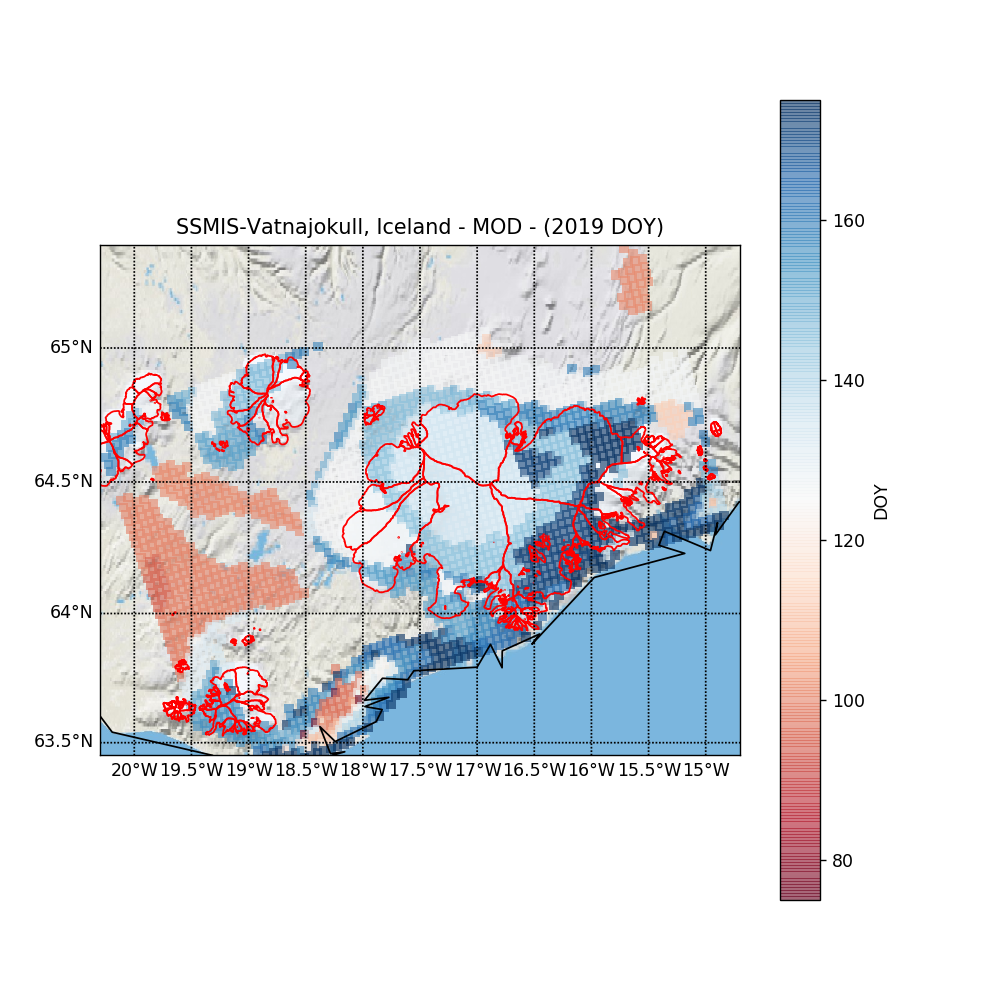

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-2259785.6631034533,9211452.331441257,-1636396.5146611212,9709184.545658551&bboxSR=3857&imageSR=3857&size=1500,1197&dpi=96&format=png32&f=image


<IPython.core.display.Javascript object>


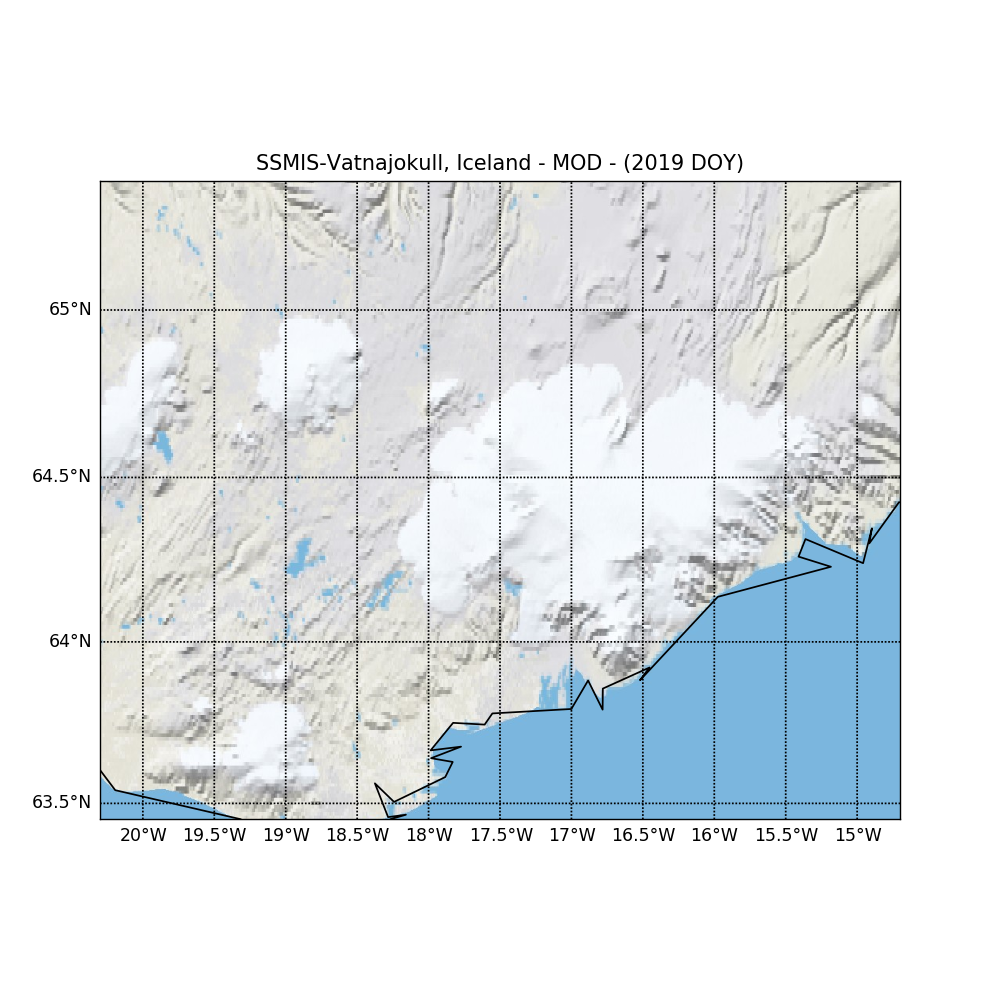

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-2259785.6631034533,9211452.331441257,-1636396.5146611212,9709184.545658551&bboxSR=3857&imageSR=3857&size=1500,1197&dpi=96&format=png32&f=image


In [22]:
# PLOT the MOD MAP - avg of all years or one year of interest - SIR

# Choose plot type - 'year' for one year of interest, 'all' for average of all years
plot_type='year'  
#plot_type='all'

#year=2018


if plot_type=='all':
    array=MOD_DOY_array
    title=sensor_SIR+'-'+Site+' - MOD - (Avg DOY '+str(Years[0])+'-'+str(Years[-1])+')'
elif plot_type=='year':
    array=MOD_DOY_array_year
    title=sensor_SIR+'-'+Site+' - MOD - ('+str(year)+' DOY)'

fig = plt.figure(figsize=(8,8))
# create figure and axes instances
#fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Iceland', color='red', linewidth=1)

x,y=m(pixel_lons, pixel_lats)
#NOTE TO JOAN MAY WANT TO CHANGE COLOR BAR
m.scatter(x,y,c=array, s=30, marker='s',lw=0,cmap='RdBu', alpha=.6)
plt.title(title)

plt.colorbar(label='DOY')
plt.clim(75,175)  #color bar limits

plt.show()


# plot another blank map with no pixel overlay
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)


plt.title(title)
plt.show()


<IPython.core.display.Javascript object>


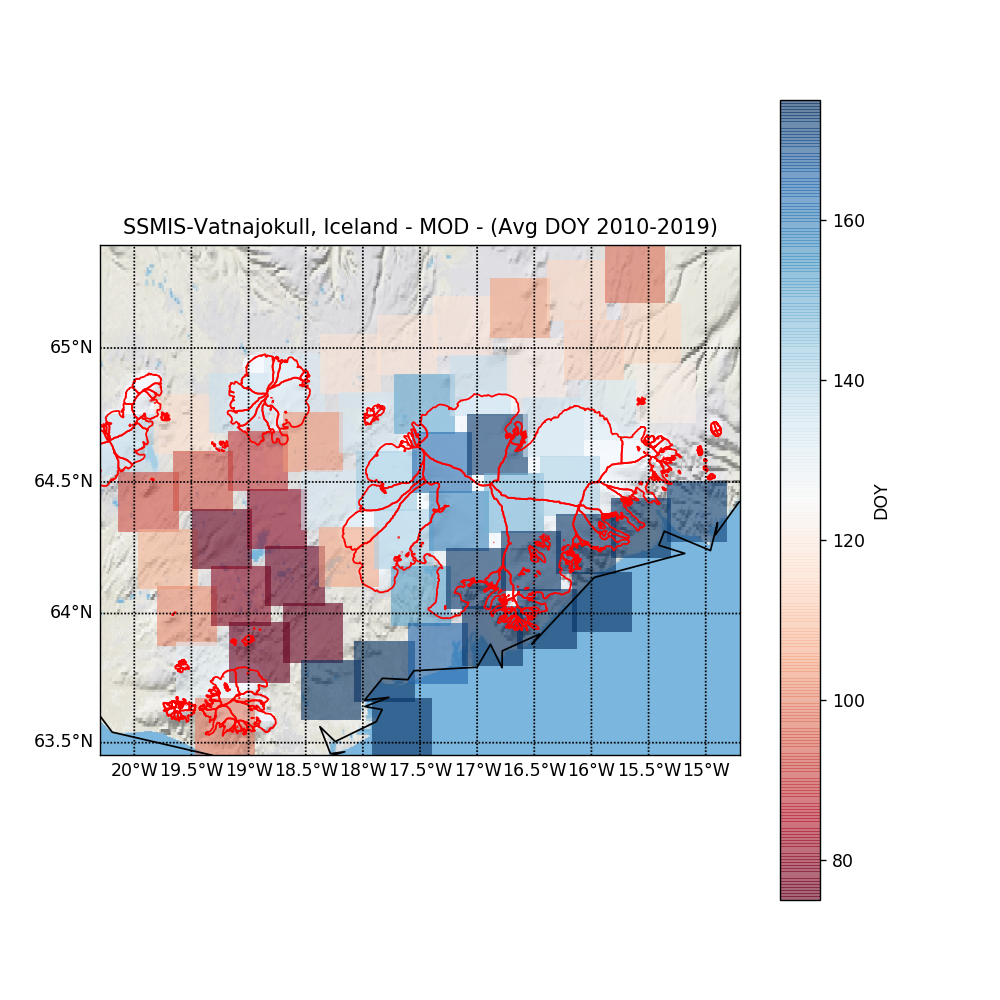

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-2259785.6631034533,9211452.331441257,-1636396.5146611212,9709184.545658551&bboxSR=3857&imageSR=3857&size=1500,1197&dpi=96&format=png32&f=image


<IPython.core.display.Javascript object>


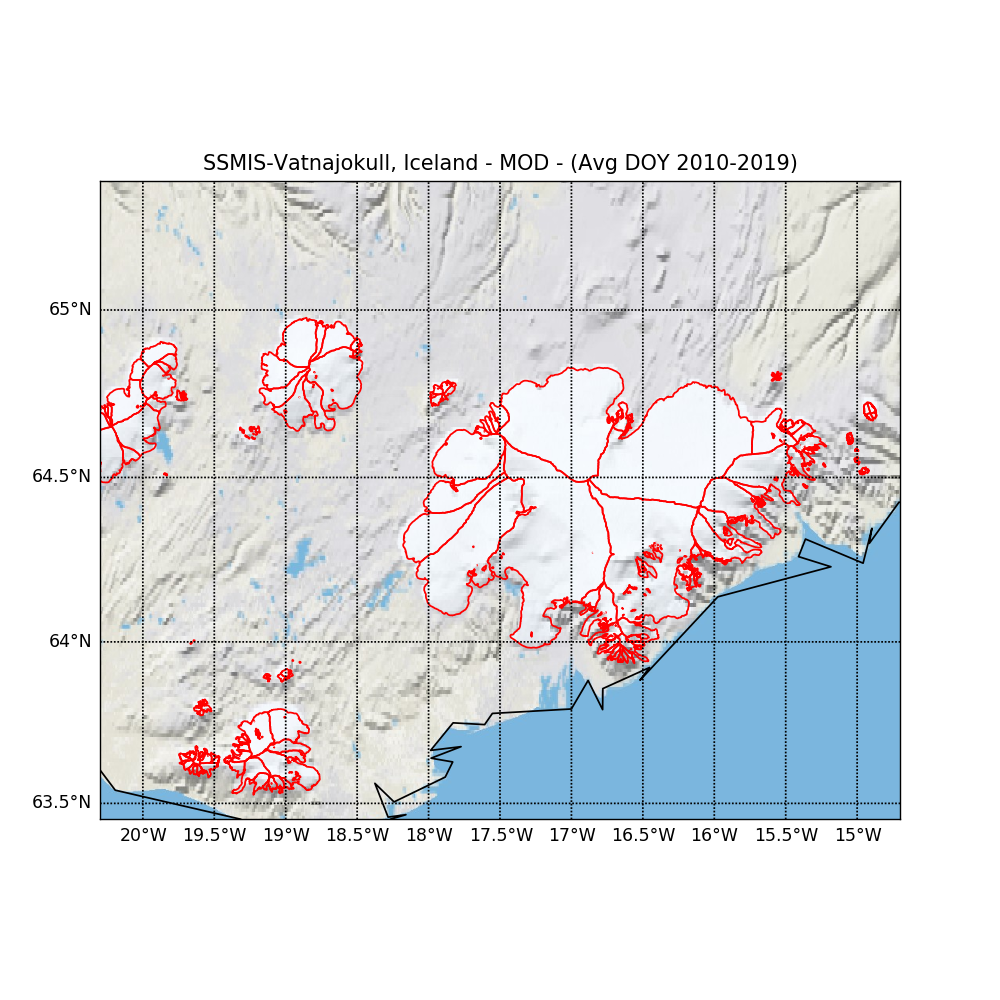

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-2259785.6631034533,9211452.331441257,-1636396.5146611212,9709184.545658551&bboxSR=3857&imageSR=3857&size=1500,1197&dpi=96&format=png32&f=image


In [23]:
# PLOT the MOD MAP - avg of all years or one year of interest - GRD
# Choose plot type - 'year' for one year of interest, 'all' for average of all years
#plot_type='year'  
plot_type='all'

#year=2018


if plot_type=='all':
    array=MOD_DOY_array_GRD
    title=sensor_SIR+'-'+Site+' - MOD - (Avg DOY '+str(Years[0])+'-'+str(Years[-1])+')'
elif plot_type=='year':
    array=MOD_DOY_array_GRD_year
    title=sensor_SIR+'-'+Site+' - MOD - ('+str(year)+' DOY)'

fig = plt.figure(figsize=(8,8))
# create figure and axes instances
#fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
#m.drawstates()
#m.etopo(scale=3, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

x,y=m(pixel_lons_GRD, pixel_lats_GRD)
m.scatter(x,y,c=array, s=1200, marker='s',lw=0,cmap='RdBu', alpha=.6)

plt.title(title)

plt.colorbar(label='DOY')
plt.clim(75,175)  #color bar limits

plt.show()


# plot another blank map with no pixel overlay
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)
#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

plt.title(title)
plt.show()